# Application for Univariate Time Series: Algorithmic Trading Model for $/₺ Exchange Rates

- <b>Univariate Time Series: ARIMA<b>

In [88]:
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yahoofinancials as yf
import requests
import ftplib
import io

<b>Let's download the Dataset from Yahoo Finance<b>

In [89]:
history = yf.YahooFinancials('USDTRY=X').get_historical_price_data('2017-01-01', '2020-01-01', 'daily')

df = pd.DataFrame(history['USDTRY=X']['prices'])

df = df.drop(['date'], axis=1)
df["formatted_date"] = pd.to_datetime(df['formatted_date'])
df = df.set_index('formatted_date')
df.head()

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2017-01-02,3.54485,3.52440,3.53490,3.53490,0.0,3.53490
2017-01-03,3.60310,3.53529,3.54280,3.54190,0.0,3.54190
2017-01-04,3.59310,3.56700,3.59115,3.59230,0.0,3.59230
2017-01-05,3.63486,3.55536,3.56930,3.56937,0.0,3.56937
2017-01-06,3.63600,3.59137,3.59270,3.59191,0.0,3.59191


<b>We draw the 3-year $/₺ rate from Yahoo Finanace, covering the trading days between 01-01-2017 and 12-31-2020. In the data set, we record the daily opening rate, also called OHLC, intraday high and low exchange rates, and closing rate data as Pandas dataframe. Let's create a new series by taking the differences between the closing rates. This is essentially a one-day trading return. We should pay attention to two things about this variable, which we call "Return", that is, return: 1) Return cannot be calculated for the first trading day in the data set. Because Return is the exchange rate change between the previous day and that trading day. Therefore, it will write Nan (not available - non available) in the Return cell corresponding to the first trading day. 2) We actually obtained the Return variable by applying the difference stationary process to the Close (Close price) series.<b>

<b>Let's create the "return" variable by taking the closing exchange rate difference.<b>

In [90]:
df["returns"] = df["close"].diff()

- <b>Grapp : Closing Price and Return Rate Together<b>

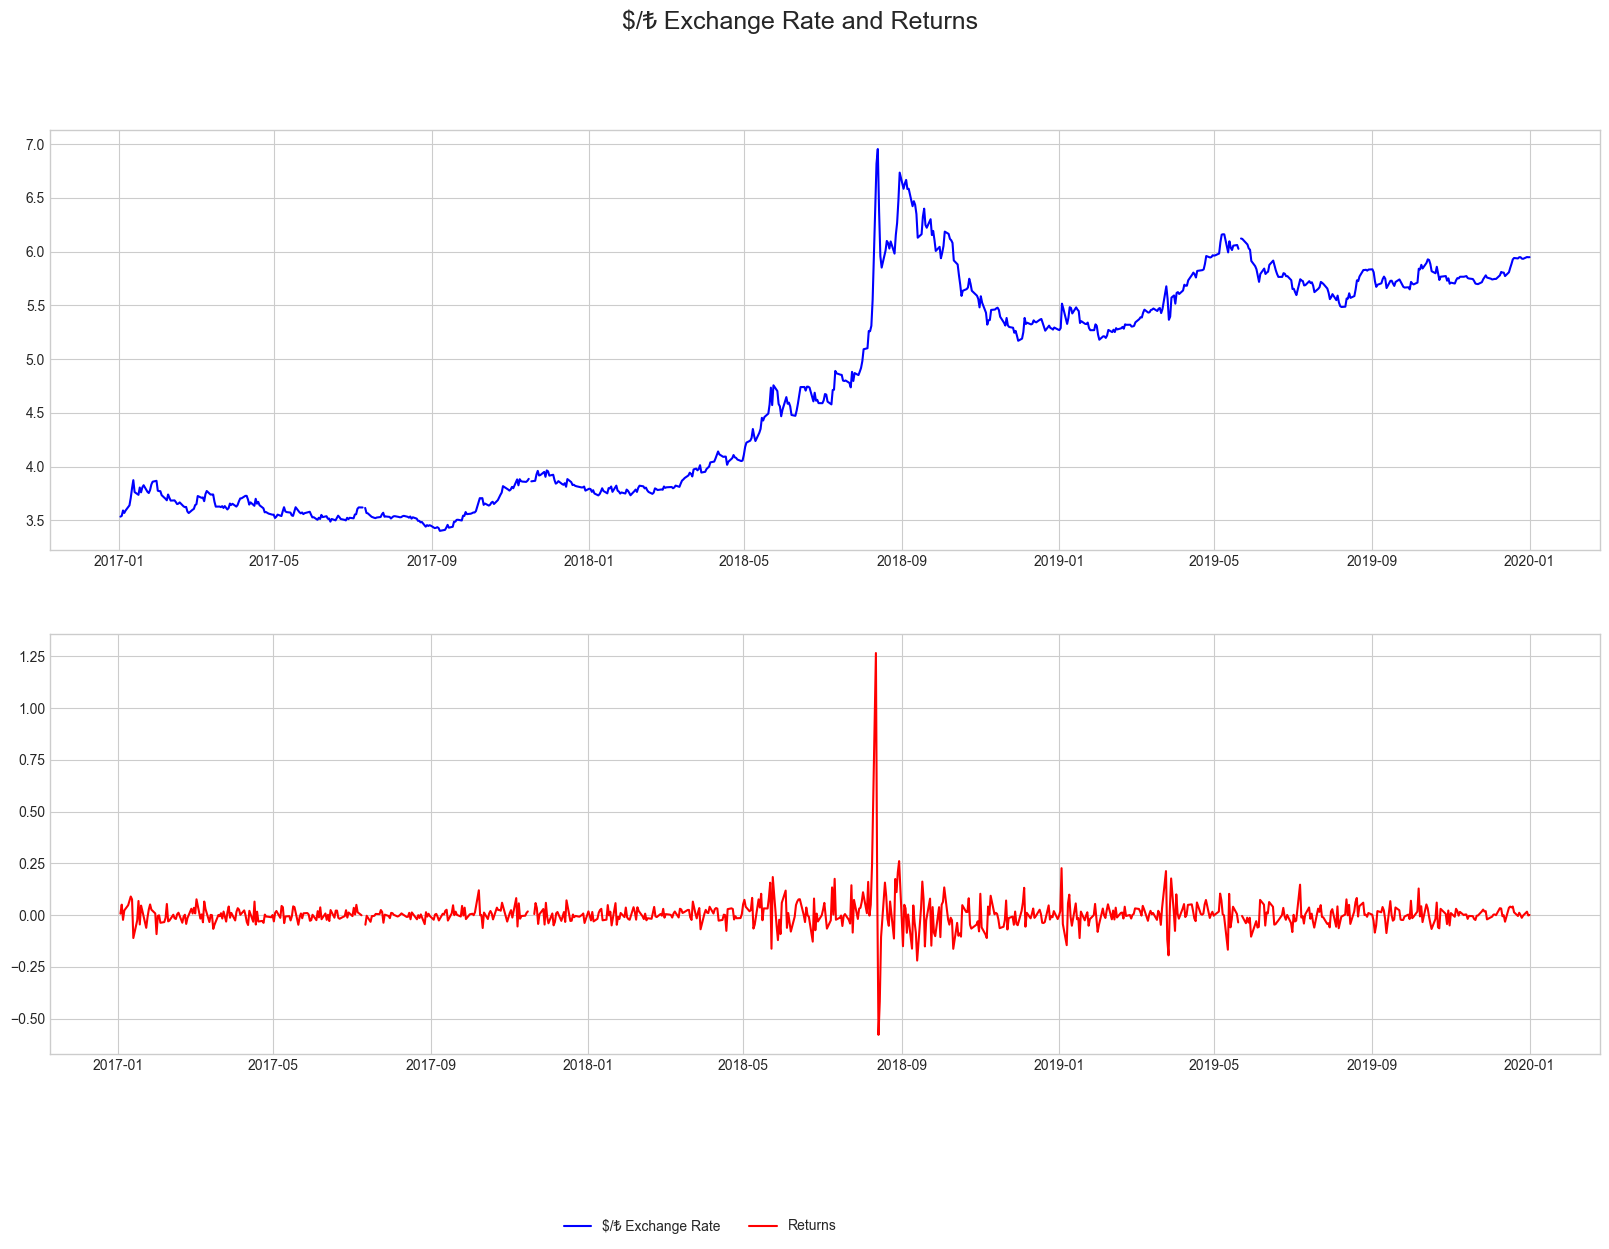

In [91]:
f = plt.figure(figsize=(20,12))
f.suptitle("$/₺ Exchange Rate and Returns", fontsize=18)
plt.subplot(211)
plt.plot(df["close"], color='blue')
plt.grid(True)
plt.subplot(212)
plt.plot(df["returns"], color='red')
f.legend(["$/₺ Exchange Rate", "Returns"], loc='lower center', ncol=2,bbox_to_anchor=(0.45, -0.05))
plt.grid(True)
plt.show()

<b>As can be seen from the graph, while the closing rate is a non-stationary series, it looks like a stationary series by taking the first difference. However, unit root tests should be used to be sure.<b>

<b>Total positive and negative returns over the period.<b>

In [92]:
print("Total positive returns: ", df[df["returns"] > 0].shape[0])
print("Total negative returns: ", df[df["returns"] < 0].shape[0])

Total positive returns:  400
Total negative returns:  375


<b>Basic Stats for Return

In [93]:
df["returns"].describe()

count    776.000000
mean       0.003022
std        0.073055
min       -0.578400
25%       -0.021698
50%        0.000735
75%        0.024542
max        1.265800
Name: returns, dtype: float64

- <b>Anomaly and Outlier Detection<b>

In [94]:
len(df)

783

<b>Interquantil Method

[<AxesSubplot: >]

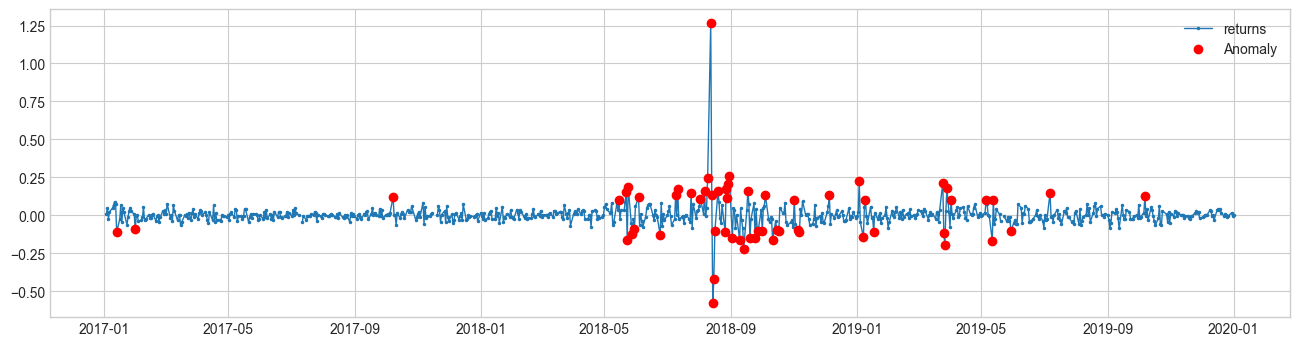

In [95]:
from adtk.detector import InterQuartileRangeAD

iqr = InterQuartileRangeAD(c=1.5)
anomalies = iqr.fit_detect(df["returns"])

# Graphical representation
from adtk.visualization import plot
plot(df["returns"], anomaly=anomalies, ts_linewidth=1, ts_markersize=3, 
    anomaly_color='red', anomaly_tag='marker', anomaly_markersize=6, anomaly_alpha=0.8)

<b>Drop Anomalies

In [96]:
not_outliers = anomalies != 1

df = df[not_outliers]

len(df)

724

<b>1) Are Series Stationary?<b>

- <b>Augmented Dickey-Fuller Test<b>

<b>2) Is Series Normal Distribution? <b>

- <b>auto-correlation<b>

<b>3) Is Series Normal Distribution?<b>

- <b>Graph Method<b>
- <b>Jarque-Bera test<b>

In [97]:
df.dropna(inplace=True)
len(df)

717

In [98]:
# Augmented Dickey-Fuller test (close)

from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df["close"])

print("ADF Statistic: %f" % adf_result[0])
print("p-value: %f" % adf_result[1])

if adf_result[1] > 0.05:
    print("The series is not stationary")
else:
    print("The series is stationary")

ADF Statistic: -0.735094
p-value: 0.837449
The series is not stationary


In [99]:
# Augmented Dickey-Fuller test (return)

adf_result = adfuller(df["returns"])

print("ADF Statistic: %f" % adf_result[0])
print("p-value: %f" % adf_result[1])

if adf_result[1] > 0.05:
    print("The series is not stationary")
else:
    print("The series is stationary")

ADF Statistic: -19.452080
p-value: 0.000000
The series is stationary


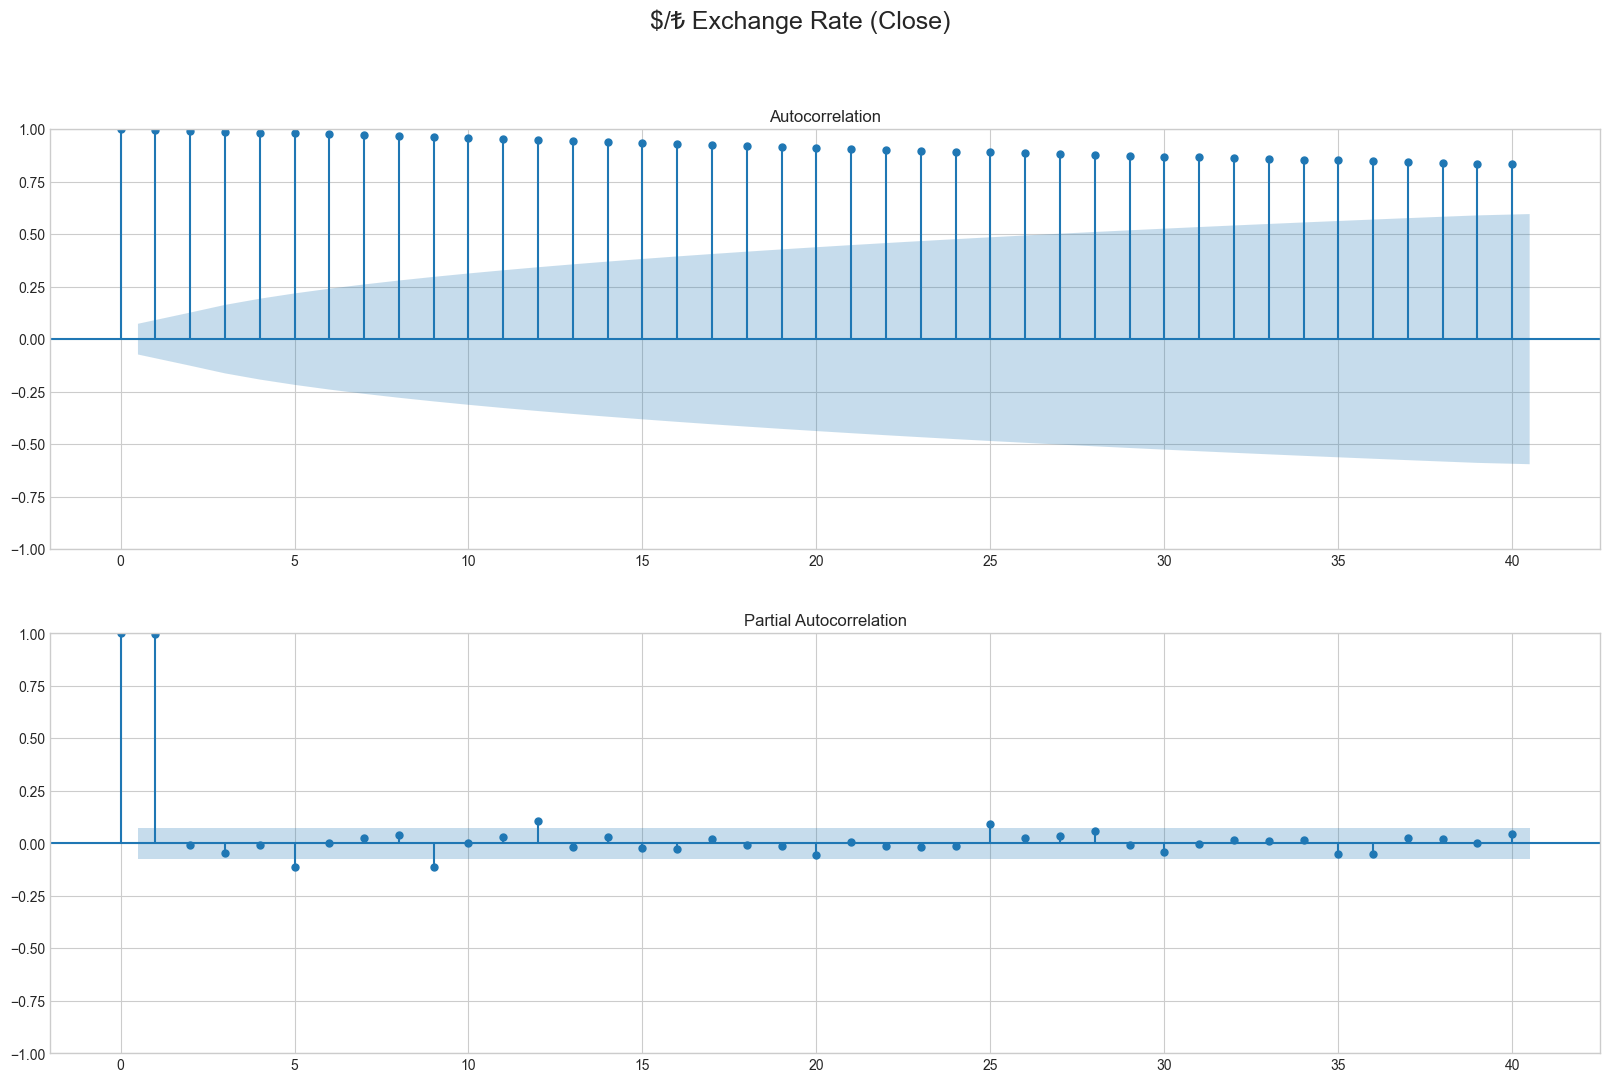

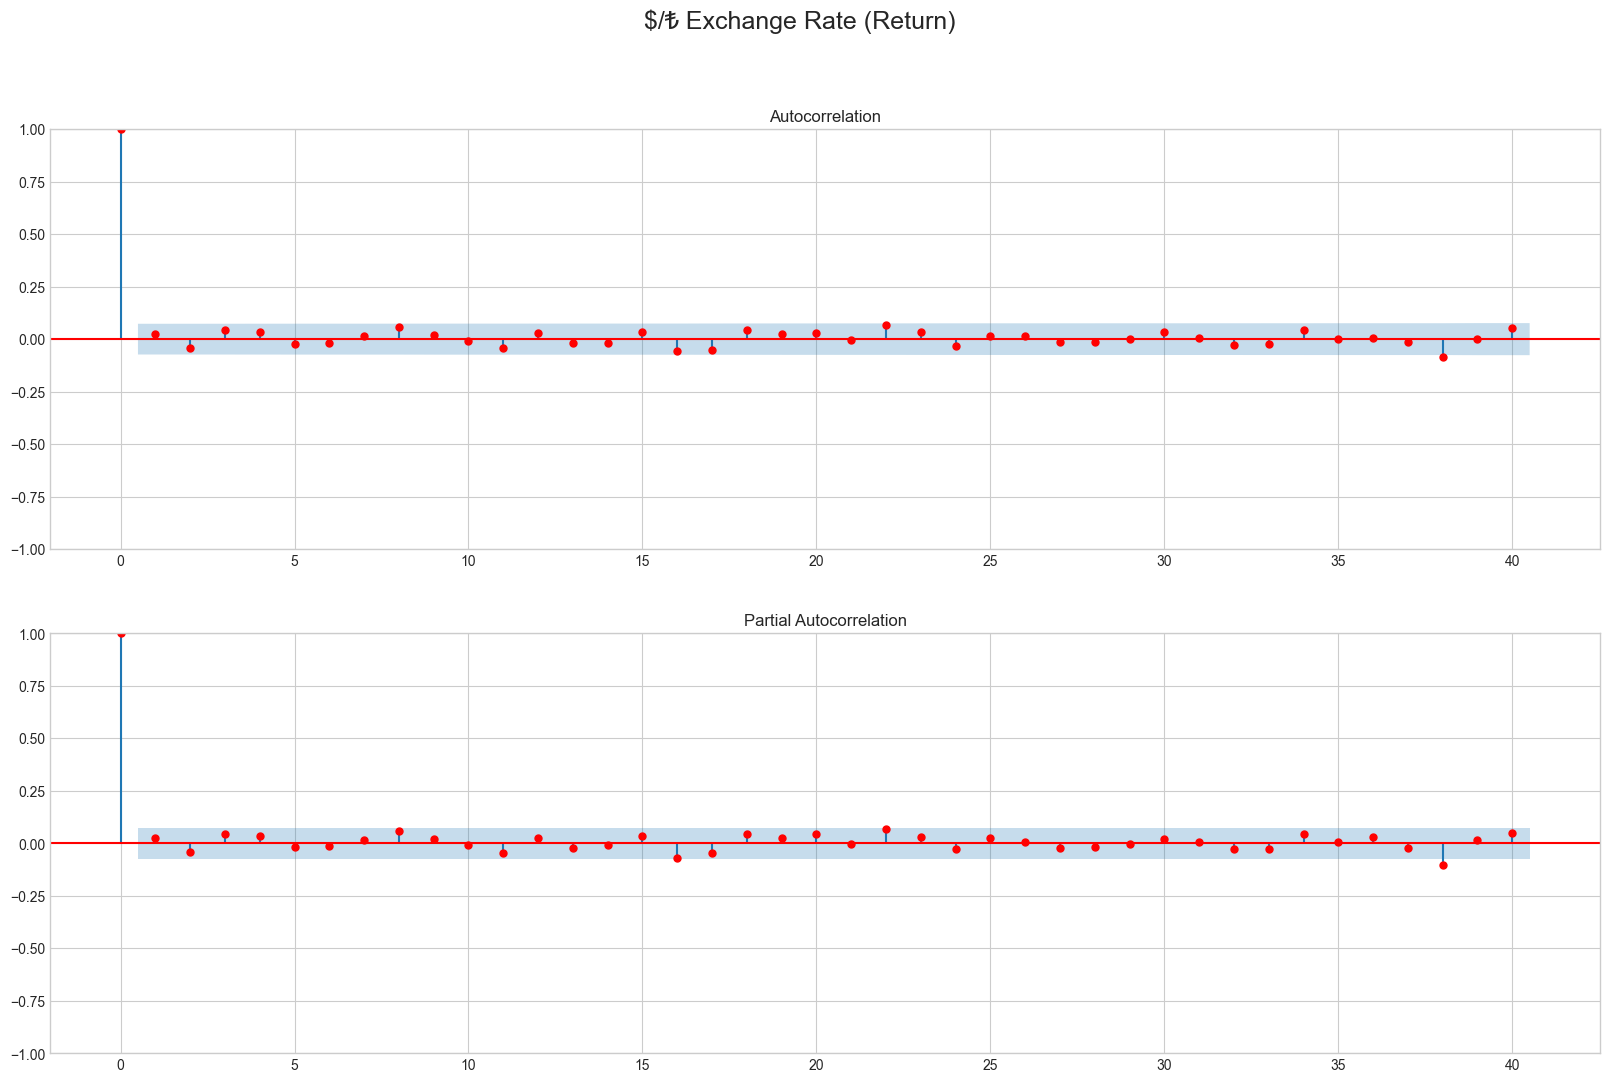

In [100]:
# auto-correlation and partial auto-correlation (close)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f = plt.figure(figsize=(20,12))
f.suptitle("$/₺ Exchange Rate (Close)", fontsize=18)
ax1 = f.add_subplot(211)
fig = plot_acf(df["close"], lags=40, ax=ax1)
ax2 = f.add_subplot(212)
fig = plot_pacf(df["close"], lags=40, ax=ax2)

# auto-correlation and partial auto-correlation (return)

f = plt.figure(figsize=(20,12))
f.suptitle("$/₺ Exchange Rate (Return)", fontsize=18)
ax1 = f.add_subplot(211)
fig = plot_acf(df["returns"], lags=40, ax=ax1,color='red')
ax2 = f.add_subplot(212)
fig = plot_pacf(df["returns"], lags=40, ax=ax2,color='red')



stat : 85.644 , p : 0.000
Close series is not normally distributed
stat : 0.817 , p : 0.665
Return series is normally distributed


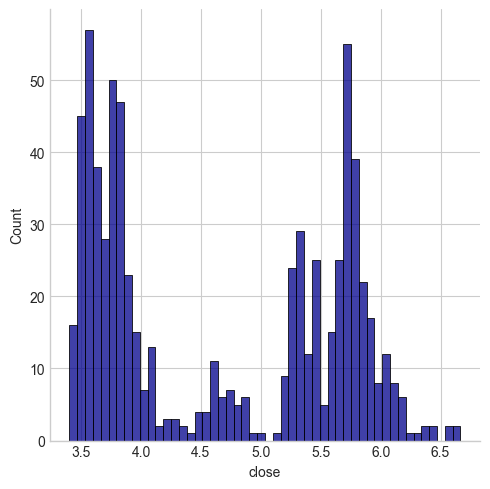

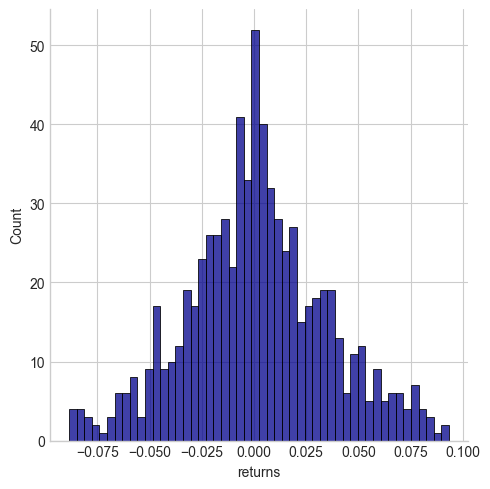

In [114]:
# Graph Method for auto-correlation

# close
sns.displot(df["close"],kind="hist",color='darkblue',bins=50,kde_kws={'linewidth': 4,'shade':True})

# return 
sns.displot(df["returns"],kind="hist",color='darkblue',bins=50,kde_kws={'linewidth': 4,'shade':True})

# Jarque-Bera test (close)

from scipy.stats import jarque_bera

stat,p = jarque_bera(df["close"])

print("stat : %.3f , p : %.3f" %(stat,p))

if p > 0.05:
    print("Close series is normally distributed")
else:
    print("Close series is not normally distributed")

# Jarque-Bera test (return)

stat,p = jarque_bera(df["returns"])

print("stat : %.3f , p : %.3f" %(stat,p))

if p > 0.05:
    print("Return series is normally distributed")

else:
    print("Return series is not normally distributed")




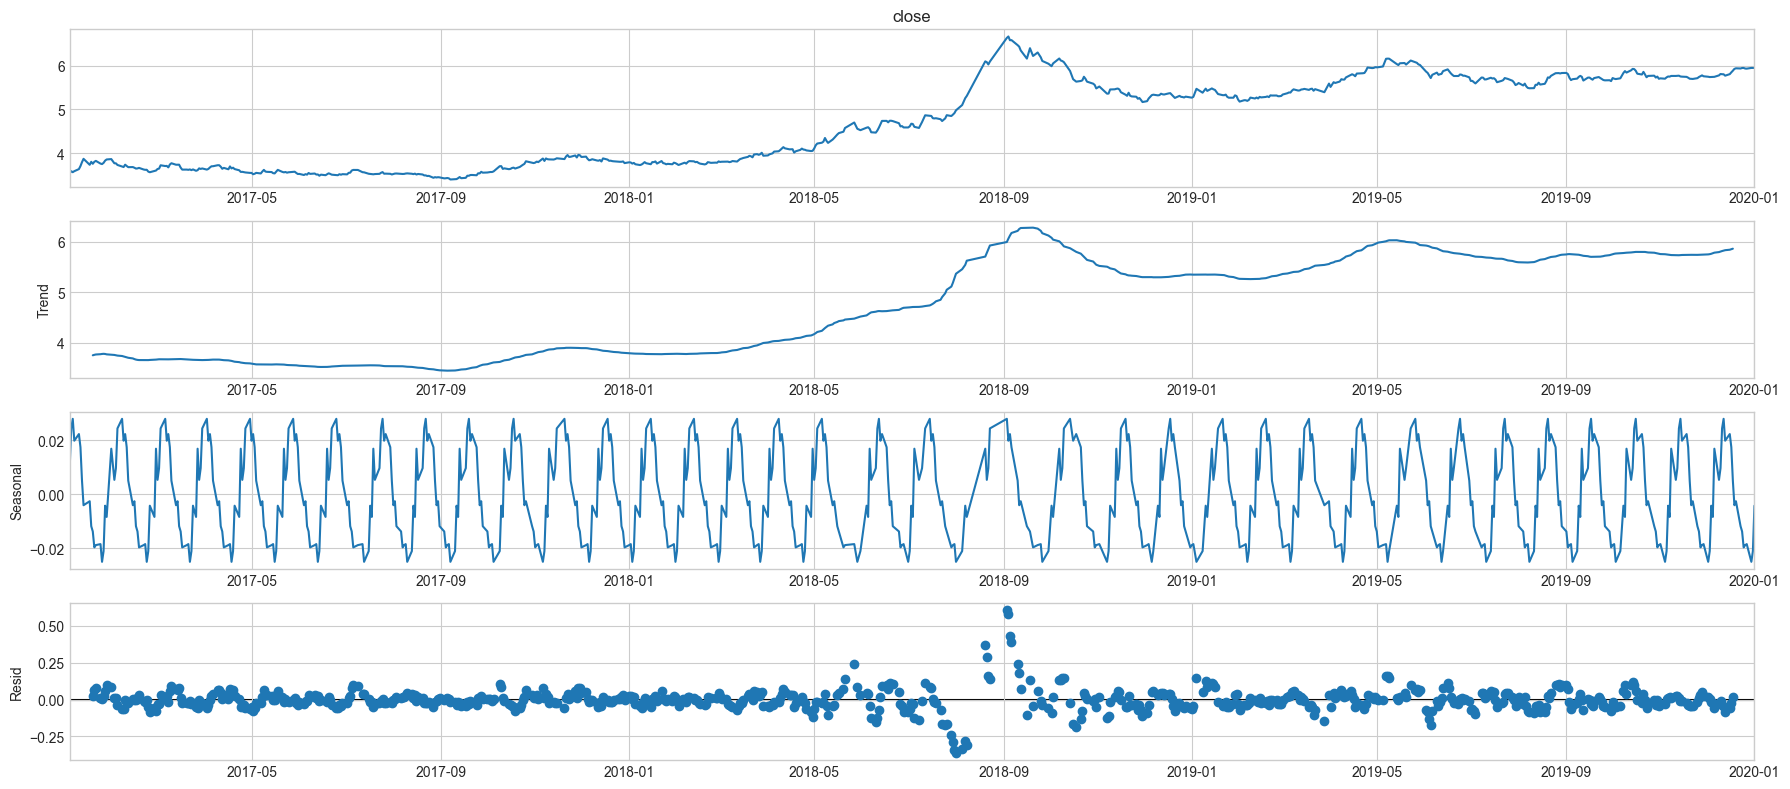

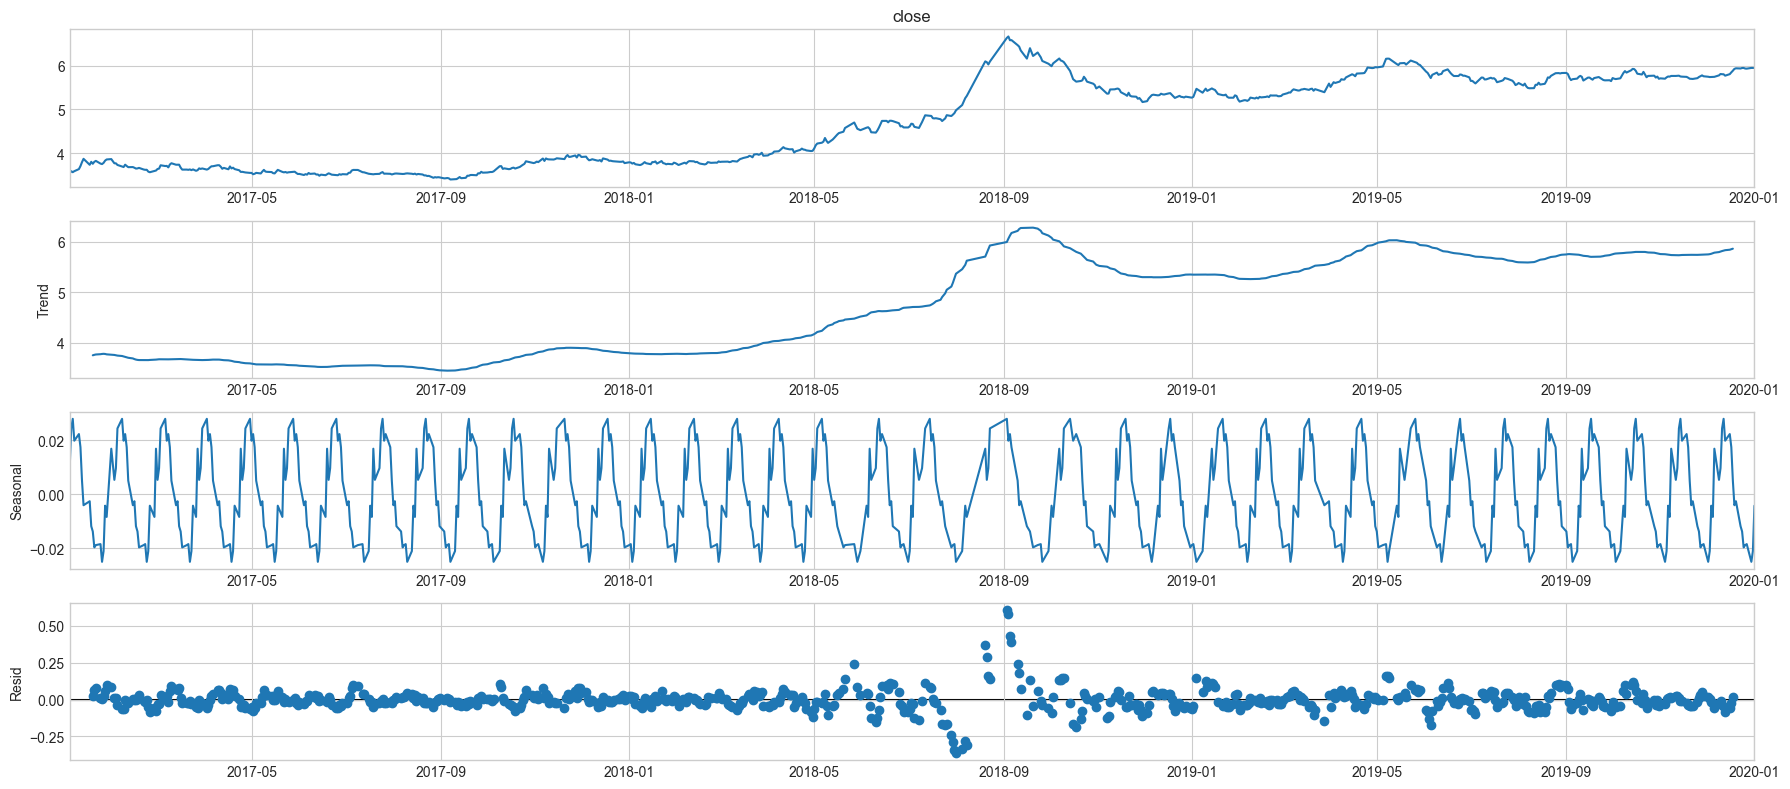

In [117]:
# Decomposition plot (close)

from pylab import rcParams

rcParams['figure.figsize'] = 18, 8

from statsmodels.tsa.seasonal import seasonal_decompose

sd_result = seasonal_decompose(df["close"], model='additive', period=20)

sd_result.plot()


<b>freq = 20 was chosen because there is data for 717 trading days. We need to divide these data into intervals of 717/36 months = 20 days to see if it has a monthly periodicity.<b>

<b>The first chart contains the time series itself.

The second graph is the Trend graph. The Close variable generally has an upward trend. The trend gives us a clue that an autoregressive process should be followed. That is, the value of the data at time t is correlated with its past values. Therefore, in order to estimate the value of the data at time t, It is necessary to include historical values in the model as explanatory or predictive.

The third graph shows the periodic change. It is clearly seen that there is a certain periodicity in the exchange rate.

The fourth graph contains residuals representing the error component, also called "white noise". Here we can see how random and unpredictable the movements in the time series are.<b>